In [15]:
import numpy as np
import pysindy as ps
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from pysindy.differentiation import SmoothedFiniteDifference

# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

In [2]:
# toy example
t = np.linspace(0, 1, 100)
x = 3 * np.exp(-2 * t)
y = 0.5 * np.exp(t)
X = np.stack((x, y), axis=-1)  # First column is x, second is y
model = ps.SINDy(feature_names=["x", "y"])
model.fit(X, t=t)
model.print()

(x)' = -2.000 x
(y)' = 1.000 y


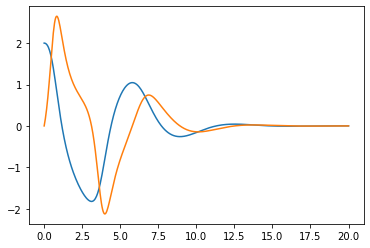

In [3]:
def vf(x, t):
    x1, x2 = x
    y = [-x2, x1 - (1-x1**2)*x2]
    return y

z0=[2,0]
t = np.linspace(0,20,501)
xx=odeint(vf, z0, t)
plt.figure(1)
plt.plot(t, xx[0],t,xx[1])
plt.show()


In [4]:
X = np.stack((xx[0], xx[1]), axis=-1)  # First column is x, second is y
model = ps.SINDy(feature_names=["x1", "x2"])
model.fit(X, t=t)
model.print()

(x1)' = -0.999 x2
(x2)' = 1.374 x1 + -0.291 x2 + 0.267 x1^2 + -0.134 x1 x2


In [4]:
def vf(t, x):
    
    y = [
#                                             
# f0
#
    0.1989532507*x[0]**2 + (-0.3746986930*x[1] - 0.2736437748*x[2] - 0.2102338351*x[3] + 0.2970740265*x[4] + 0.3127680623*x[5] - 0.01669120692*x[6] + 0.06998703340*x[7] + 0.1066092874*x[8] - 0.2932731139*x[9] - 0.9897508136)*x[0] + 0.2290160726*x[1]**2 + (0.3043283662*x[3] - 0.3427339422*x[4] - 0.2909684040*x[5] - 0.03766820776*x[6] - 0.07013143585*x[7] - 0.00335077278*x[8] + 0.2338743069*x[9] + 0.3113173115*x[2] + 2.118681547)*x[1] + 0.1313269044*x[2]**2 + (0.1667773216*x[3] - 0.1858768786*x[4] - 0.1692031675*x[5] + 0.01835581154*x[6] + 0.00527957798*x[7] - 0.06204132445*x[8] + 0.2154590805*x[9] + 0.1822937756)*x[2] + 0.1199134206*x[3]**2 + (2.172824903 - 0.2551625097*x[4] - 0.1918810479*x[5] - 0.06853344320*x[6] - 0.07820043220*x[7] + 0.06778326492*x[8] + 0.08851262462*x[9])*x[3] + 0.1568361752*x[4]**2 + (-0.5637474356 + 0.2785805234*x[5] + 0.05602401930*x[6] + 0.1146148356*x[7] - 0.01948672995*x[8] - 0.1556286023*x[9])*x[4] + 0.1435362729*x[5]**2 + (-0.2301950413 + 0.01687965377*x[6] + 0.1072316619*x[7] + 0.05135244079*x[8] - 0.1987347825*x[9])*x[5] + 0.02620179645*x[6]**2 + (-0.4449045860 + 0.03970147617*x[7] - 0.08136302008*x[8] + 0.05945874215*x[9])*x[6] + 0.03840002526*x[7]**2 + (-0.5863033921 - 0.03022933302*x[8] - 0.008721167594*x[9])*x[7] + 0.07453193438*x[8]**2 + (0.4328101506 - 0.1462574559*x[9])*x[8] + 0.1297231241*x[9]**2 - 0.5424980712*x[9], \
#
# f1
#
    -0.03119605894*x[0]**2 + (0.03153737407*x[1] + 0.02865595927*x[2] + 0.02168237588*x[3] - 0.02614983431*x[4] - 0.04282878632*x[5] + 0.02164051571*x[6] - 0.03368328076*x[7] - 0.04208070200*x[8] + 0.04677950036*x[9] - 0.1917995579)*x[0] - 0.06349682805*x[1]**2 + (-0.09745019444*x[3] + 0.04945719986*x[4] - 0.00725858798*x[5] + 0.02585816683*x[6] - 0.02172930153*x[7] - 0.05729940663*x[8] - 0.00472767777*x[9] - 0.1008048758*x[2] - 0.9781859725)*x[1] - 0.04847610961*x[2]**2 + (-0.07334570982*x[3] + 0.02014055021*x[4] - 0.02193176669*x[5] + 0.00400591788*x[6] - 0.02336554649*x[7] - 0.02794496258*x[8] - 0.01466478795*x[9] + 0.2309047484)*x[2] - 0.04468166437*x[3]**2 + (0.3530648809 + 0.03806553631*x[4] - 0.00958980908*x[5] + 0.01985044356*x[6] + 0.00338308209*x[7] - 0.04926706550*x[8] + 0.00867868591*x[9])*x[3] - 0.02396569262*x[4]**2 + (-0.3232326202 - 0.03328791432*x[5] - 0.02185224895*x[6] - 0.006289928862*x[7] + 0.02470076015*x[8] + 0.006350783469*x[9])*x[4] - 0.03091558700*x[5]**2 + (0.1323309042 + 0.005453947198*x[6] - 0.03389417380*x[7] - 0.03330007197*x[8] + 0.03192852100*x[9])*x[5] - 0.01708198358*x[6]**2 + (-0.2935693423 + 0.02368730120*x[7] + 0.05290764966*x[8] - 0.02653836321*x[9])*x[6] - 0.03264090370*x[7]**2 + (0.3896692795 - 0.04363254132*x[8] + 0.01548131327*x[9])*x[7] - 0.04769659728*x[8]**2 + (0.0406197547 + 0.05115811655*x[9])*x[8] - 0.02359950588*x[9]**2 + 0.3082568899*x[9], \
#
# f2
#
    0.09126920252*x[0]**2 + (-0.1837466357*x[1] - 0.1402352655*x[2] - 0.09333759420*x[3] + 0.1367085329*x[4] + 0.1392944946*x[5] - 0.004746979466*x[6] + 0.008913711408*x[7] + 0.04466682909*x[8] - 0.1419498381*x[9] + 0.4429513679)*x[0] + 0.08604337194*x[1]**2 + (0.1167735712*x[3] - 0.1719416349*x[4] - 0.1755942083*x[5] - 0.01586866373*x[6] - 0.06849556991*x[7] - 0.02366391257*x[8] + 0.1123154339*x[9] + 0.09334227143*x[2] + 0.8483485581)*x[1] + 0.04745814984*x[2]**2 + (0.01663354444*x[3] - 0.06366398541*x[4] - 0.09727931370*x[5] + 0.03667693045*x[6] + 0.00704277082*x[7] - 0.08784867008*x[8] + 0.1362490790*x[9] - 1.339521793)*x[2] + 0.05641452990*x[3]**2 + (0.4347532629 - 0.1560583242*x[4] - 0.1344069171*x[5] - 0.05856437772*x[6] - 0.07929013343*x[7] + 0.05241477736*x[8] + 0.01542903334*x[9])*x[3] + 0.09141768969*x[4]**2 + (-0.1542947132 + 0.1528726246*x[5] + 0.05254559419*x[6] + 0.09417777322*x[7] - 0.04554532504*x[8] - 0.04130436855*x[9])*x[4] + 0.06354104563*x[5]**2 + (-0.2794559621 + 0.03150409182*x[6] + 0.05344407299*x[7] - 0.02077146017*x[8] - 0.06800121637*x[9])*x[5] + 0.01925982710*x[6]**2 + (-0.2336276914 + 0.06731834571*x[7] - 0.05515809304*x[8] + 0.05114591974*x[9])*x[6] + 0.01615005377*x[7]**2 + (-0.0515408280 - 0.08914645939*x[8] + 0.04059226652*x[9])*x[7] + 0.04122032728*x[8]**2 + (0.8823743331 - 0.09773115730*x[9])*x[8] + 0.07650499903*x[9]**2 - 1.155048593*x[9], \
#
# f3
#
    0.000109942824*x[0]**2 + (0.03356003711*x[1] + 0.02323754113*x[2] + 0.00169041486*x[3] - 0.02142491959*x[4] - 0.00609162685*x[5] - 0.02233368253*x[6] + 0.04709505532*x[7] + 0.02719344765*x[8] + 0.008265219448*x[9] - 0.1137458510)*x[0] + 0.03197569451*x[1]**2 + (0.04898642207*x[3] + 0.02341326976*x[4] + 0.07907578307*x[5] - 0.01172494990*x[6] + 0.05515845861*x[7] + 0.05594327922*x[8] - 0.02797966001*x[9] + 0.07626223517*x[2] - 0.1083576192)*x[1] + 0.02909993375*x[2]**2 + (0.08900483976*x[3] - 0.01029067114*x[4] + 0.05280784502*x[5] - 0.02698774480*x[6] + 0.00162851924*x[7] + 0.07655040292*x[8] - 0.04988285377*x[9] + 0.0239831175)*x[2] + 0.01495956764*x[3]**2 + (-1.358618607 + 0.04667987187*x[4] + 0.07423590124*x[5] + 0.02888526563*x[6] + 0.03992297246*x[7] - 0.00590631655*x[8] + 0.01222698222*x[9])*x[3] - 0.02129293989*x[4]**2 + (0.3472755899 - 0.03514987692*x[5] - 0.01526279489*x[6] - 0.05575042410*x[7] + 0.01838663898*x[8] - 0.01413149723*x[9])*x[4] + 0.00514768156*x[5]**2 + (0.04020270346 - 0.02730319070*x[6] + 0.00264941851*x[7] + 0.05676910300*x[8] - 0.01935545563*x[9])*x[5] + 0.005122385702*x[6]**2 + (0.3644515720 - 0.08075939614*x[7] - 0.01655858027*x[8] - 0.009837097207*x[9])*x[6] + 0.02676284738*x[7]**2 + (-0.4038672971 + 0.1196289080*x[8] - 0.05813179940*x[9])*x[7] + 0.02015960523*x[8]**2 + (-0.2065587443 + 0.01057956599*x[9])*x[8] - 0.01601044456*x[9]**2 - 0.0008795611*x[9], \
#
# f4
#
    -0.2356044784*x[0]**2 + (0.4368128924*x[1] + 0.3204293413*x[2] + 0.2365468824*x[3] - 0.3493291689*x[4] - 0.3732874301*x[5] + 0.02131713778*x[6] - 0.07468835444*x[7] - 0.1323523275*x[8] + 0.3533971562*x[9] - 0.0147421268)*x[0] - 0.2881631989*x[1]**2 + (-0.3922286193*x[3] + 0.4183395990*x[4] + 0.3322599789*x[5] + 0.06113214538*x[6] + 0.07439919177*x[7] - 0.03002028856*x[8] - 0.2610498978*x[9] - 0.3909324168*x[2] - 2.513633472)*x[1] - 0.1710301966*x[2]**2 + (-0.2039744307*x[3] + 0.2119339561*x[4] + 0.1792833848*x[5] - 0.02206378047*x[6] - 0.03533658575*x[7] + 0.06523807313*x[8] - 0.2597492202*x[9] + 0.0058670390)*x[2] - 0.1607874011*x[3]**2 + (-2.932118792 + 0.3280215592*x[4] + 0.2249495230*x[5] + 0.1106050218*x[6] + 0.09367156110*x[7] - 0.1297453395*x[8] - 0.07572266747*x[9])*x[3] - 0.1963810687*x[4]**2 + (-0.1638866308 - 0.3393330884*x[5] - 0.08319592584*x[6] - 0.1563249011*x[7] + 0.04866923811*x[8] + 0.1643626100*x[9])*x[4] - 0.1783682454*x[5]**2 + (-0.01574759993 - 0.02307362569*x[6] - 0.1464116533*x[7] - 0.06300056683*x[8] + 0.2314048086*x[9])*x[5] - 0.03758648386*x[6]**2 + (0.7011482314 - 0.06668855334*x[7] + 0.1199722527*x[8] - 0.08903013289*x[9])*x[6] - 0.05150059121*x[7]**2 + (0.8443117014 + 0.05607924857*x[8] - 0.00683385188*x[9])*x[7] - 0.1104573804*x[8]**2 + (-0.2014154915 + 0.2039944943*x[9])*x[8] - 0.1653286974*x[9]**2 + 0.7888676929*x[9], \
#
# f5
#
    -0.03174802457*x[0]**2 + (0.05911882435*x[1] + 0.04118114352*x[2] + 0.05552296569*x[3] - 0.04328142128*x[4] - 0.04200774476*x[5] + 0.008727285361*x[6] - 0.04465726422*x[7] - 0.01664032178*x[8] + 0.03237310870*x[9] + 0.1579262048)*x[0] - 0.01791799780*x[1]**2 + (-0.009411239820*x[3] + 0.02263073203*x[4] + 0.03793097508*x[5] - 0.01960010700*x[6] + 0.005530186985*x[7] + 0.04075797187*x[8] - 0.05528394634*x[9] - 0.03854900403*x[2] + 0.03153139574)*x[1] - 0.003957642423*x[2]**2 + (-0.04938561448*x[3] + 0.04837433752*x[4] + 0.04476630099*x[5] + 0.008011272630*x[6] + 0.05172384447*x[7] - 0.004710467487*x[8] - 0.006542628740*x[9] - 0.00004526793)*x[2] + 0.009286895212*x[3]**2 + (0.4183096855 - 0.02476813038*x[4] + 0.005774825732*x[5] - 0.05415973363*x[6] - 0.004755324375*x[7] + 0.08186419541*x[8] - 0.07189362880*x[9])*x[3] + 0.002734306575*x[4]**2 + (-0.2447161610 - 0.01343966645*x[5] + 0.02761137963*x[6] + 0.04112490938*x[7] - 0.05053718746*x[8] + 0.06648193594*x[9])*x[4] - 0.009523852257*x[5]**2 + (-1.072403800 + 0.01350498951*x[6] + 0.01737425917*x[7] - 0.02618165575*x[8] + 0.04625523647*x[9])*x[5] + 0.005661597163*x[6]**2 + (-0.3402218983 + 0.06127583477*x[7] - 0.02336802754*x[8] + 0.02817641673*x[9])*x[6] - 0.005787224408*x[7]**2 + (-0.4745740131 - 0.07904022308*x[8] + 0.05538942517*x[9])*x[7] + 0.02058694156*x[8]**2 + (-0.09495866683 - 0.03683770877*x[9])*x[8] + 0.006912559033*x[9]**2 + 0.2490206693*x[9], \
#
# f6
#
    0.1739533759*x[0]**2 + (-0.3350244126*x[1] - 0.2054790966*x[2] - 0.1959672537*x[3] + 0.3103898852*x[4] + 0.3181229624*x[5] + 0.02350429586*x[6] + 0.07526826939*x[7] + 0.05519418672*x[8] - 0.2381640501*x[9] - 0.5378125466)*x[0] + 0.2513311465*x[1]**2 + (0.3109764237*x[3] - 0.2814626018*x[4] - 0.1873593607*x[5] - 0.02699517830*x[6] + 0.02851400816*x[7] + 0.02125324314*x[8] + 0.2309699675*x[9] + 0.4020442606*x[2] + 2.585332115)*x[1] + 0.1334347191*x[2]**2 + (0.2919387892*x[3] - 0.2617660208*x[4] - 0.1432345559*x[5] - 0.08826316063*x[6] - 0.00076569878*x[7] + 0.1222633182*x[8] + 0.09091655005*x[9] + 0.2561420917)*x[2] + 0.07545659716*x[3]**2 + (2.542831014 - 0.1275443760*x[4] - 0.07122014199*x[5] + 0.00514544561*x[6] + 0.09527869569*x[7] - 0.01040956002*x[8] + 0.1738949378*x[9])*x[3] + 0.08218611817*x[4]**2 + (-0.7890598197 + 0.1888004602*x[5] - 0.06126798233*x[6] + 0.006889206886*x[7] + 0.1371789889*x[8] - 0.2666446160*x[9])*x[4] + 0.1345284350*x[5]**2 + (0.3109352756 - 0.05845032969*x[6] + 0.07910512525*x[7] + 0.1740364179*x[8] - 0.2632871889*x[9])*x[5] - 0.02871106046*x[6]**2 + (-1.366679846 - 0.04144626131*x[7] + 0.05913188175*x[8] - 0.05223764083*x[9])*x[6] - 0.02060051357*x[7]**2 + (-1.384868757 + 0.1103834035*x[8] - 0.1166681038*x[9])*x[7] - 0.00914009550*x[8]**2 + (-0.1625218280 + 0.00459133672*x[9])*x[8] + 0.06107966045*x[9]**2 - 0.4706103342*x[9], \
#
# f7
#
    0.01026552266*x[0]**2 + (-0.03187199823*x[1] - 0.000793892722*x[2] - 0.006817269314*x[3] + 0.05253478837*x[4] + 0.04826223157*x[5] + 0.03010087018*x[6] - 0.01665094710*x[7] - 0.02311028685*x[8] - 0.01389664226*x[9] + 0.01072576625)*x[0] + 0.04465813378*x[1]**2 + (0.05183681743*x[3] - 0.02933197294*x[4] + 0.00197779221*x[5] - 0.009304296549*x[6] + 0.03393734096*x[7] + 0.02260391674*x[8] + 0.02473116542*x[9] + 0.08144097749*x[2] + 0.0839783228)*x[1] + 0.02013705004*x[2]**2 + (0.06269877891*x[3] - 0.05618655542*x[4] - 0.00871464069*x[5] - 0.04890000622*x[6] + 0.02458367844*x[7] + 0.07608987663*x[8] - 0.02040374062*x[9] + 0.1489519871)*x[2] + 0.00039422616*x[3]**2 + (0.2834837759 - 0.002012048238*x[4] + 0.01705106847*x[5] - 0.00613322295*x[6] + 0.07468263469*x[7] + 0.01269193177*x[8] + 0.02836445274*x[9])*x[3] - 0.004844618104*x[4]**2 + (0.1022313303 + 0.006472913374*x[5] - 0.03959570966*x[6] - 0.005062325930*x[7] + 0.05777729645*x[8] - 0.06015458404*x[9])*x[4] + 0.01868943770*x[5]**2 + (0.2943094090 - 0.02766542499*x[6] + 0.01453396782*x[7] + 0.05662635001*x[8] - 0.05120727162*x[9])*x[5] - 0.02522525361*x[6]**2 + (0.0610179633 + 0.01135788886*x[7] + 0.05760306257*x[8] - 0.03650363659*x[9])*x[6] - 0.03613922686*x[7]**2 + (-0.8923199381 + 0.00752835178*x[8] - 0.02308979076*x[9])*x[7] - 0.02764354738*x[8]**2 + (0.05671007885 + 0.03665775857*x[9])*x[8] - 0.006001738490*x[9]**2 - 0.0055618391*x[9], \
#
# f8
#
    -0.09497689057*x[0]**2 + (0.2033638856*x[1] + 0.1543259758*x[2] + 0.09198433443*x[3] - 0.1517072956*x[4] - 0.1499516593*x[5] - 0.005105339724*x[6] + 0.01612675299*x[7] - 0.03649260188*x[8] + 0.1543198753*x[9] - 0.6170313489)*x[0] - 0.08415143357*x[1]**2 + (-0.1156429920*x[3] + 0.1956427857*x[4] + 0.2118813826*x[5] + 0.01925860657*x[6] + 0.09088343953*x[7] + 0.03301652747*x[8] - 0.1222703039*x[9] - 0.07532946735*x[2] - 0.7131782561)*x[1] - 0.04407164271*x[2]**2 + (0.01795231881*x[3] + 0.05905475196*x[4] + 0.1149279646*x[5] - 0.04908548282*x[6] - 0.02093089967*x[7] + 0.1196897096*x[8] - 0.1654653973*x[9] - 0.1337325061)*x[2] - 0.06074929836*x[3]**2 + (-0.4153924395 + 0.1951969424*x[4] + 0.1712998574*x[5] + 0.08779734655*x[6] + 0.09882053116*x[7] - 0.08073725812*x[8] + 0.00246810218*x[9])*x[3] - 0.1093617712*x[4]**2 + (-0.3728978824 - 0.1790889267*x[5] - 0.06834408938*x[6] - 0.1323482164*x[7] + 0.06613930496*x[8] + 0.02867347676*x[9])*x[4] - 0.06810240048*x[5]**2 + (-0.1121429909 - 0.04569519334*x[6] - 0.06384020970*x[7] + 0.04452776278*x[8] + 0.06137463992*x[9])*x[5] - 0.02015889163*x[6]**2 + (0.0856712443 - 0.1156422534*x[7] + 0.05954172996*x[8] - 0.06537260972*x[9])*x[6] - 0.006709718858*x[7]**2 + (-0.5124228674 + 0.1555251638*x[8] - 0.07569905099*x[9])*x[7] - 0.04354340949*x[8]**2 + (-1.551265696 + 0.1198169906*x[9])*x[8] - 0.09198037687*x[9]**2 + 0.5566902787*x[9], \
#
# f9
#
    -0.09232767692*x[0]**2 + (0.1904204383*x[1] + 0.1455960453*x[2] + 0.1187073538*x[3] - 0.1336287631*x[4] - 0.1297547816*x[5] + 0.01060859589*x[6] - 0.03772521545*x[7] - 0.04286793828*x[8] + 0.1300771420*x[9] - 0.7092622233)*x[0] - 0.05666641978*x[1]**2 + (-0.06203987819*x[3] + 0.1430835258*x[4] + 0.1866932260*x[5] - 0.01452406761*x[6] + 0.07908192648*x[7] + 0.08094520091*x[8] - 0.1368656089*x[9] - 0.05905368372*x[2] - 0.2049764995)*x[1] - 0.02236405851*x[2]**2 + (-0.01640167184*x[3] + 0.07648862568*x[4] + 0.1280311791*x[5] - 0.03710059262*x[6] + 0.05225490874*x[7] + 0.09863638176*x[8] - 0.1221829736*x[9] + 0.4033796050)*x[2] - 0.02448892244*x[3]**2 + (0.2759641204 + 0.09892082831*x[4] + 0.1278596095*x[5] - 0.00461560933*x[6] + 0.07971345454*x[7] + 0.04569970809*x[8] - 0.07175585739*x[9])*x[3] - 0.06881919807*x[4]**2 + (-0.4598420200 - 0.1297055428*x[5] - 0.02257652501*x[6] - 0.04458789173*x[7] - 0.000069693141*x[8] + 0.07684569429*x[9])*x[4] - 0.04758821665*x[5]**2 + (-0.03588032938 - 0.02367467985*x[6] - 0.01566547170*x[7] + 0.02002302507*x[8] + 0.07530333027*x[9])*x[5] - 0.01126895539*x[6]**2 + (-0.0548398499 - 0.01120011014*x[7] + 0.02141068881*x[8] - 0.01851571759*x[9])*x[6] - 0.01531694108*x[7]**2 + (-0.1896173202 + 0.02610044084*x[8] + 0.00192671788*x[9])*x[7] - 0.00693600439*x[8]**2 + (-0.4822097733 + 0.04238410906*x[9])*x[8] - 0.05279133763*x[9]**2 - 0.2873669021*x[9] \
    ]
    return y

In [112]:
# Generate measurement data
dt = .001

t_train = np.arange(0, 10, dt)
x0_train = [0, 1]
# x0_train = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
t_train_span = (t_train[0], t_train[-1])
dim = 2
multiple = False

# def vf(t, x):
#     x1, x2 = x
#     y = [-x2, x1 - (1-x1**2)*x2]
#     return y

# Van der Pol ODE
def van_der_pol(t, x, p=[1]):
    return [-x[1],  x[0] - p[0] * (1 - x[0] ** 2) * x[1]]

# def vf(t, x):
#     x1 = x[0]
#     x2 = x[1]
#     y = [-x1 - 2*x2 + x1**3, -x2 + 0.5 * x1 **2 * x2 + x1 ** 3]
#     return y

In [113]:
if multiple:
    n_trajectories = 20
    x_train_multi = []
    x0s = np.random.rand(n_trajectories, dim)
    for i in range(n_trajectories):
        x_train_temp = solve_ivp(fun = van_der_pol, t_span=t_train_span, 
                                    y0 = x0s[i], t_eval=t_train, **integrator_keywords).y.T
        x_train_multi.append(x_train_temp)
    print('done with ivp')

x_train = solve_ivp(fun = van_der_pol, t_span = t_train_span, y0 = x0_train, t_eval=t_train, **integrator_keywords).y.T

In [114]:
fourier_lib = ps.FourierLibrary(n_frequencies=5)
poly_lib = ps.PolynomialLibrary(degree=20)
identity_lib = ps.IdentityLibrary()

tensor_lib =identity_lib + fourier_lib + poly_lib + fourier_lib*poly_lib 
# Instantiate and fit the SINDy model
# lasso_optimizer = Lasso(alpha=0.0001, max_iter=2000, fit_intercept=False)
diff_method = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
# threshold is the lambda
opt = ps.optimizers.STLSQ(threshold=0.01, alpha = 0.1, max_iter=2000, normalize_columns=False, fit_intercept=False)
# lib = ps.PolynomialLibrary(degree=20).fit(x_train)
lib = tensor_lib.fit(x_train)
# lib.get_feature_names()

In [115]:
model = ps.SINDy(optimizer=opt, feature_library=lib, differentiation_method=diff_method)
model.fit(x_train, t=dt, multiple_trajectories=multiple)
print('score: {}'.format(model.score(x_train, dt)))
model.print()

score: 0.9999999999999976
(x0)' = 268760.408 x1 + 238261.324 sin(1 x1) + -320551.575 sin(2 x1) + 112681.926 sin(3 x1) + 314792.986 x1 + -1209436.838 x1^3 + 10.958 cos(1 x0) x1 + 9.256 cos(1 x0) x1^3 + 234768.313 sin(1 x1) 1 + 1372697.779 sin(1 x1) x1^2 + -142527.907 cos(1 x1) x1 + -1017816.487 cos(1 x1) x1^3 + -3.714 cos(2 x0) x1 + -4.343 cos(2 x0) x1^3 + -76220.145 sin(2 x1) 1 + -1017030.746 sin(2 x1) x1^2 + 177835.804 sin(2 x1) x1^4 + -0.916 sin(3 x0) x0 x1 + 1.109 cos(3 x0) x1^3 + 111413.036 sin(3 x1) 1 + -888149.146 cos(3 x1) x1 + 0.200 sin(4 x0) x0 x1 + -0.015 sin(4 x0) x1^3 + -0.115 cos(4 x0) x1^3 + 36375.369 sin(4 x1) x1^2 + 95344.328 cos(4 x1) x1 + -3834.185 cos(4 x1) x1^3 + 0.011 sin(5 x0) x1^3
(x1)' = -369873.968 x0 + -23761.232 x1 + 58724.295 sin(1 x0) + 86354.502 cos(1 x0) + -12489.659 sin(1 x1) + 60714.815 sin(2 x0) + -20345.329 sin(2 x1) + 4620.661 sin(3 x0) + 23435.120 cos(3 x0) + 19632.020 sin(3 x1) + -12563.715 sin(4 x0) + -21629.125 cos(4 x0) + -176773.969 1 + 65206.4

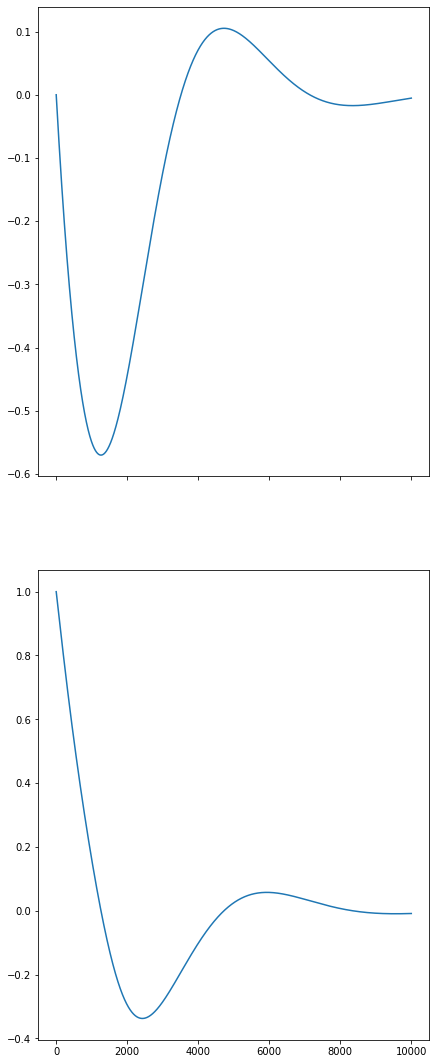

In [116]:
fig, axs = plt.subplots(x_train.shape[1], 1, sharex=True, figsize=(7, 19))
for i in range(x_train.shape[1]):
    axs[i].plot(x_train[:,i])


In [117]:
# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 10, dt)
x0_test = np.array([0, 0.5])
# x0_test = np.array([1, 1, 0, 1, 1, 1, 0, 1, 1, 1])
t_test_span = (t_test[0], t_test[-1])
x_test = solve_ivp(van_der_pol, t_test_span, x0_test,
                   t_eval=t_test, **integrator_keywords).y.T
# Compare SINDy-predicted derivatives with finite difference derivatives
print('Model score: %f' % model.score(x_test, t=dt))

Model score: 0.371665


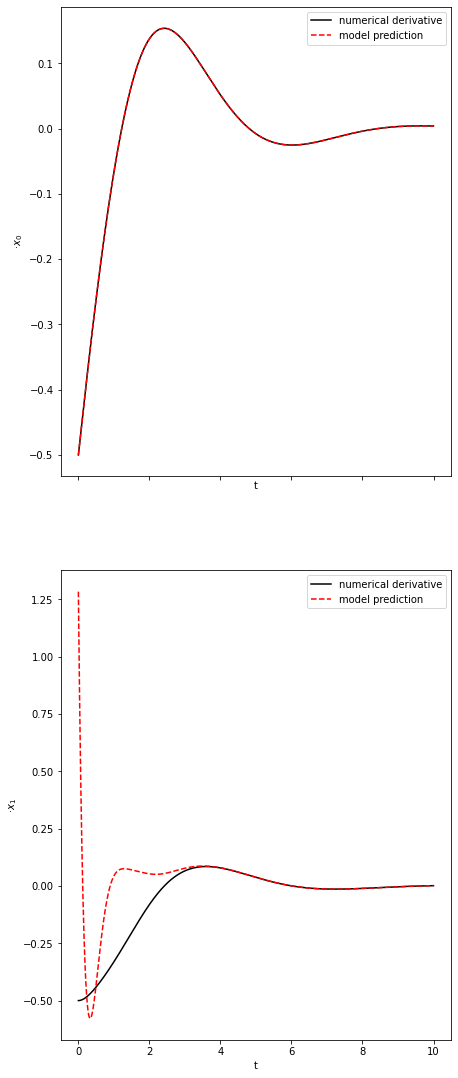

In [118]:
# Predict derivatives using the learned model
x_dot_test_predicted = model.predict(x_test)

# Compute derivatives with a finite difference method, for comparison
x_dot_test_computed = model.differentiate(x_test, t=dt)

fig, axs = plt.subplots(x_test.shape[1], 1, sharex=True, figsize=(7, 19))
for i in range(x_test.shape[1]):
    axs[i].plot(t_test, x_dot_test_computed[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_test, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
# fig.show()


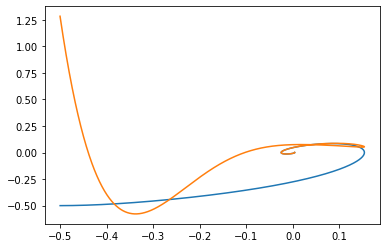

In [119]:
plt.plot(x_dot_test_computed[:,0], x_dot_test_computed[:,1])
plt.plot(x_dot_test_predicted[:,0], x_dot_test_predicted[:,1])

In [57]:
def my_vf(t, x):
    y = [-x[1], x[0] - (1-x[0]**2)*x[1]]
    return y
trial_x = np.array([[1.1,1.3]])
my_vf(np.random.normal(), trial_x)

IndexError: index 1 is out of bounds for axis 0 with size 1

In [29]:
model.predict(trial_x).tolist()

[[-1.2999094579485697, 1.3726473140045414]]

In [31]:
import tensorflow as tf
tf.transpose(tf.convert_to_tensor(model.predict(trial_x), dtype=tf.float32))

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-1.2999095],
       [ 1.3726473]], dtype=float32)>

In [21]:
bounds = [1.6, 4]
numpoints = 20
# define plotting range and mesh
x = np.linspace(-bounds[0], bounds[0], numpoints)
y = np.linspace(-bounds[1], bounds[1], numpoints)

X, Y = np.meshgrid(x, y)

s = X.shape

Ze = np.zeros(s)
Zp = np.zeros(s)
DT = np.zeros((numpoints**2,2))

# convert mesh into point vector for which the model can be evaluated
c = 0
for i in range(s[0]):
    for j in range(s[1]):
        DT[c,0] = X[i,j]
        DT[c,1] = Y[i,j]
        c = c+1;
vf_that_works =  np.array(my_vf(np.random.normal(), DT)).T
predicted = model.predict(DT)

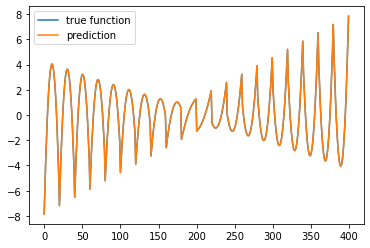

In [22]:
plt.plot(vf_that_works[:,1], label = 'true function')
plt.plot(predicted[:,1], label = 'prediction')
plt.legend()
plt.show()

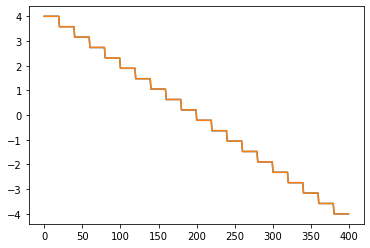

In [23]:
plt.plot(vf_that_works[:,0])
plt.plot(predicted[:,0])

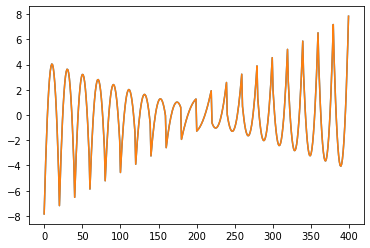

In [25]:
plt.plot(vf_that_works[:,1])
plt.plot(predicted[:,1])